데이터 변환 과정과 머신러닝 모델을 쉽게 연결해주는 Pipeline 파이썬 클래스  
(Pipeline과 GridSearchCV를 함께 사용하여 각 처리 단계에서 필요한 매개변수 탐색을 동시에 수행)

In [1]:
# %load basic
from IPython.display import set_matplotlib_formats, display
import numpy as np
import pandas as pd
import graphviz
import os
import mglearn
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
from cycler import cycler
%matplotlib inline

font_name = font_manager.FontProperties(fname = "C:/Windows/Fonts/H2GTRM.TTF").get_name()
rc('font', family = font_name)
matplotlib.rcParams['axes.unicode_minus'] = False

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
plt.rcParams['image.cmap'] = "viridis"
plt.rcParams['image.interpolation'] = "none"
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.numpoints'] = 1
plt.rc('axes', prop_cycle=(
    cycler('color', mglearn.plot_helpers.cm_cycle.colors) +
    cycler('linestyle', ['-', '-', "--", (0, (3, 3)), (0, (1.5, 1.5))])))

np.set_printoptions(precision=3, suppress=True)

pd.set_option("display.max_columns", 8)
pd.set_option('precision', 2)

__all__ = ['np', 'mglearn', 'display', 'plt', 'pd']

C:\Users\hyooo\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\hyooo\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# 데이터를 분할하고 최솟값, 최댓값을 찾아 데이터의 스케일을 바꾸고 SVM을 훈련시키는 코드
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 적재와 분할
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state = 0)

# 훈련 데이터의 최솟값, 최댓값을 계산합니다.
scaler = MinMaxScaler().fit(X_train)

In [3]:
# 훈련 데이터의 스케일을 조정합니다.
X_train_scaled = scaler.transform(X_train)
svm = SVC()

# 스케일 조정된 훈련데이터에 SVM을 학습시킵니다.
svm.fit(X_train_scaled, y_train)

# 테스트 데이터의 스케일을 조정하고 점수를 계산합니다.
X_test_scaled = scaler.transform(X_test)
print("테스트 점수 : {:.2f}".format(svm.score(X_test_scaled, y_test)))

테스트 점수 : 0.95


C:\Users\hyooo\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


# 6.1 데이터 전처리와 매개변수 선택

In [4]:
from sklearn.model_selection import GridSearchCV

# 이 코드는 예를 위한 것입니다. 실제로 사용하지 마세요.
paramg = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
          'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid = paramg, cv = 5)
grid.fit(X_train_scaled, y_train)

print("최상의 교차 검증 정확도 : {:.2f}".format(grid.best_score_))
print("테스트 점수 : {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("최적의 매개변수 : ", grid.best_params_)

최상의 교차 검증 정확도 : 0.98
테스트 점수 : 0.97
최적의 매개변수 :  {'C': 1, 'gamma': 1}


1. 데이터의 최솟값과 최댓값을 계산할 때 학습을 위해 훈련 세트에 있는 모든 데이터를 사용  
2. 스케일이 조정된 훈련 데이터에서 교차 검증을 사용해 그리드 서치 수행  
-> 데이터 스케일을 조정할 때 검증 폴드에 들어있는 정보까지 이미 사용  
-> 새로운 데이터가 관측되면 이 데이터는 훈련 데이터의 스케일 조정에 사용되지 않은 것이라 최솟값과 최댓값이 훈련 데이터와 다를 수 있음

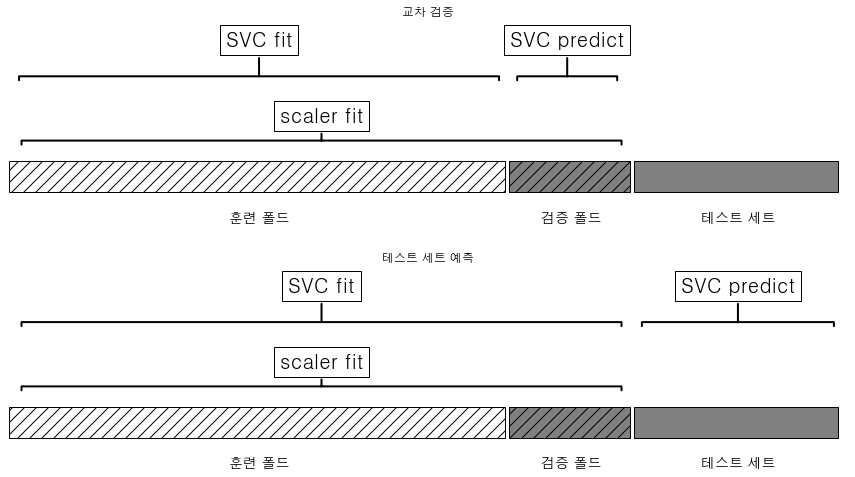

In [5]:
mglearn.plots.plot_improper_processing()

교차 검증의 분할 방식은 모델이 새 데이터를 만났을 때 올바로 분류하지 못함  
-> 이 문제를 해결하기 위해서는 교차 검증의 분할이 모든 전처리 과정보다 앞서 이뤄줘야 함  
    (데이터셋의 정보를 이용하는 모든 처리 과정은 데이터셋의 훈련 부분에만 적용되어야 하므로 교차 검증 반복 안에 있어야 함)

# 6.2 파이프라인 구축하기

#### MinMaxScaler로 데이터의 스케일을 조정하고 SVM 모델을 훈련시키는 워크플로를 Pipeline으로 표현

In [6]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC())])

In [7]:
pipe.fit(X_train, y_train)

C:\Users\hyooo\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svm',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [8]:
print("테스트 점수 : {:.2f}".format(pipe.score(X_test, y_test)))

테스트 점수 : 0.95


-> 파이프라인을 사용하면 '**전처리 + 분류**'과정을 위해 작성해야 할 코드가 줄어듦  
-> cross_va_score나 GridSearchCV에 파이프라인을 하나의 추정기처럼 사용 가능

# 6.3 그리드 서치에 파이프라인 적용하기

In [9]:
# 각 매개변수가 파이프라인의 어떤 단계에 속한 것인지 알려줘야 합니다.
paramg = {'svm__C' : [0.001, 0.01, 0.1, 1, 10, 100],
          'svm__gamma' : [0.001, 0.01, 0.1, 1, 10, 100]}

In [10]:
grid = GridSearchCV(pipe, param_grid = paramg, cv = 5)
grid.fit(X_train, y_train)
print("최상의 교차 검증 정확도 : {:.2f}".format(grid.best_score_))
print("테스트 세트 점수 : {:.2f}".format(grid.score(X_test, y_test)))
print("최적의 매개변수 :", grid.best_params_)

최상의 교차 검증 정확도 : 0.98
테스트 세트 점수 : 0.97
최적의 매개변수 : {'svm__C': 1, 'svm__gamma': 1}


-> 교차 검등의 각 분할에 MinMaxScaler가 훈련 폴드에 매번 적용되어, 매개변수 검색 과정에 검증 폴더의 정보가 누설되지 않음

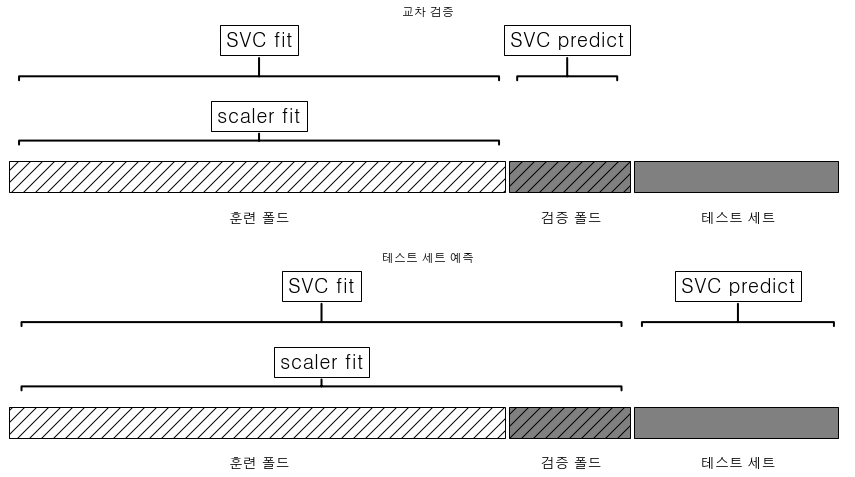

In [11]:
mglearn.plots.plot_proper_processing()

-> 교차 검증에서 정보 누설에 의한 영향은 전처리 종류에 따라 다름

#### → 정보 누설에 대한 예시←

헤이스티, 팁시라니, 프리드먼의 책 "The Elements of Statistical Learning"(Springer, 2016)의 교차 검증의 정보 누설에 대한 예

In [12]:
rnd = np.random.RandomState(seed = 0)
X = rnd.normal(size = (100, 10000))
y = rnd.normal(size = (100, ))

In [13]:
# SelectPercentile로 10,000개 중 가장 유용한 특성 선택 -> 교차 검증을 사용하여 Ridge 회귀 평가
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func = f_regression, percentile = 5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape :", X_selected.shape)

X_selected.shape : (100, 500)


In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

print("교차 검증 점수 (릿지) : {:.2f}".format(np.mean(cross_val_score(Ridge(), X_selected, y, cv = 5))))

교차 검증 점수 (릿지) : 0.91


-> 교차 검증으로 계산한 평균 R²은 0.91이므로 매우 좋은 모델  
(교차 검증 밖에서 특성을 선택했기 때문에 훈련과 테스트 폴드 양쪽에 연관된 특성이 찾아질 수 있음)

In [15]:
# 파이프라인을 사용한 교차 검증과 비교
pipe = Pipeline([('select', SelectPercentile(score_func = f_regression, percentile = 5)), ('ridge', Ridge())])
print("교차 검증 점수 (파이프라인) : {:.2f}".format(np.mean(cross_val_score(pipe, X, y, cv = 5))))

교차 검증 점수 (파이프라인) : -0.25


-> R² 점수가 음수라 성능이 매우 낮은 모델  
(특성 선택이 교차 검증 반복 안으로 들어감 - 훈련 폴드를 사용해서만 특성이 선택되어 테스트 폴드는 사용하지 않음)

**이 예는 특성 선택 단계에서 일어나는 정보 누설을 막는 것이 모델의 성능을 평가하는 데 큰 차이를 만든다는 것을 보여줌**

# 6.4 파이프라인 인터페이스

- Pipeline은 전처리나 분류에 국한하지 않고 어떤 추정기와도 연결할 수 있음  
- 파이프라인에 들어갈 추정기는 마지막 단계를 제외하고는 모두 transform 메서드를 가지고 있어야 함  
    (다음 단계를 위한 새로운 데이터 표현을 만들 수 있어야 함)

In [16]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # 마지막 단계를 빼고 fit과 transform을 반복합니다.
        X_transformed = estimator.fit_transform(X_transformed, y)
    
    # 마지막 단계 fit을 호출합니다.
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [17]:
# Pipeline을 사용해서 예측할 때는 마지막 단계 이전까지 transform 메서드를 호출한 다음, 마지막 단계에서 predict을 호출합니다.
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # 마지막 단계를 빼고 transform을 반복합니다.
        X_transformed = step[1].transform(X_transformed)
        
    # 마지막 단계 predict을 호출합니다.
    return self.steps[-1][1].predict(X_transformed)

## 6.4.1 make_pipeline을 사용한 파이프라인 생성

In [18]:
# make_pipeline 함수는 각 단계 이름에 해당 파이썬 클래스의 이름을 부여한 파이프라인을 만들어줍니다.
from sklearn.pipeline import make_pipeline
# 표준적인 방법
pipe_long = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC(C = 100))])

# 간소화된 방법
pipe_short = make_pipeline(MinMaxScaler(), SVC(C = 100))

In [19]:
print("파이프라인 단계 :\n", pipe_short.steps)

파이프라인 단계 :
 [('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False))]


-> 일반적으로 단계의 이름은 파이썬 클래스 이름의 소문자 버전

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components = 2), StandardScaler())
print("파이프라인 단계 :\n", pipe.steps)

파이프라인 단계 :
 [('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


## 6.4.2 단계 속성에 접근하기

파이프라인의 단계 중 하나의 속성을 확인하고 싶을 때,  
단계 이름을 키로 가진 딕셔너리인 named_steps속성을 사용하면 파이프라인의 각 단계에 쉽게 접근할 수 있음

In [21]:
# cancer 데이터셋에 앞서 만든 파이프라인을 적용합니다
pipe.fit(cancer.data)

# "pca" 단계의 두 개 주성분을 추출합니다
components = pipe.named_steps['pca'].components_
print("components.shape :", components.shape)

components.shape : (2, 30)


## 6.4.3 그리드 서치 안의 파이프라인 속성에 접근하기

In [22]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [23]:
paramg = {'logisticregression__C' : [0.01, 0.1, 1, 10, 100]}

In [24]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state = 4)
grid = GridSearchCV(pipe, paramg, cv = 5)
grid.fit(X_train, y_train)

C:\Users\hyooo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hyooo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hyooo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hyooo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hyooo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                     

In [25]:
print("최상의 모델 :\n", grid.best_estimator_)

최상의 모델 :
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


In [26]:
# logistic regression 단계에 접근하려면 파이프라인의 named_steps 속성 사용
print("로지스틱 회귀 단계 :\n", grid.best_estimator_.named_steps['logisticregression'])

로지스틱 회귀 단계 :
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [27]:
# 학습된 logistic regression 객체를 얻었으므로 각 입력 특성에 연결된 계수(가중치) 출력
print("로지스틱 회귀 계수 :\n", grid.best_estimator_.named_steps['logisticregression'].coef_)

로지스틱 회귀 계수 :
 [[-0.389 -0.375 -0.376 -0.396 -0.115  0.017 -0.355 -0.39  -0.058  0.209
  -0.495 -0.004 -0.371 -0.383 -0.045  0.198  0.004 -0.049  0.21   0.224
  -0.547 -0.525 -0.499 -0.515 -0.393 -0.123 -0.388 -0.417 -0.325 -0.139]]


# 6.5 전처리와 모델의 매개변수를 위한 그리드 서치

**파이프라인 장점**  
- 머신러닝 워크플로에 필요한 모든 처리 단계를 하나의 scikit-learn 추정기로 캡슐화할 수 있음  
- 회귀와 분류 같은 지도 학습의 출력을 이요해서 전처리 매개변수를 조정할 수 있음

#### 데이터 스케일 조정, 다항식 특성 선택, 리지 회귀의 세 단계로 구성된 파이프라인

In [28]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state = 0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

In [29]:
paramg = {'polynomialfeatures__degree' : [1, 2, 3],
          'ridge__alpha' : [0.001, 0.01, 0.1, 1, 10, 100]}

In [30]:
grid = GridSearchCV(pipe, param_grid = paramg, cv = 5, n_jobs = -1)
grid.fit(X_train, y_train)

C:\Users\hyooo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
         

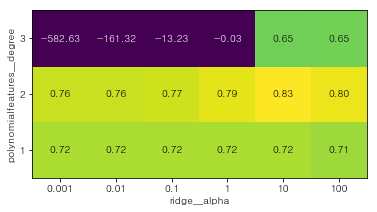

In [31]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                      xlabel = 'ridge__alpha', ylabel = 'polynomialfeatures__degree',
                      xticklabels = paramg['ridge__alpha'], yticklabels = paramg['polynomialfeatures__degree'], vmin = 0);

-> 2차항이 효과가 좋고, 3차항은 1, 2차보다 결과가 나쁨

In [32]:
# 히트맵과 같은 결과 출력됨
print("최적의 매개변수 :", grid.best_params_)

최적의 매개변수 : {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [33]:
print("테스트 세트 점수 : {:.2f}".format(grid.score(X_test, y_test)))

테스트 세트 점수 : 0.77


In [34]:
# 다항식이 없는 그리드 서치와 비교
paramg = {'ridge__alpha' : [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, paramg, cv = 5)
grid.fit(X_train, y_train)
print("다항 특성이 없을 때 점수 : {:.2f}".format(grid.score(X_test, y_test)))

다항 특성이 없을 때 점수 : 0.63


C:\Users\hyooo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


-> 다항 특성이 없는 경우 성능이 더 낮아짐

# 6.6 모델 선택을 위한 그리드 서치

GridSearchCV와 Pipeline을 연결하는 것에서 더 나아가, 파이프라인을 구성하는 단계도 탐색 대상으로 삼을 수 있음  
(ex) StandardScaler오 MinMaxScaler 중 어떤 것을 사용할지

#### cancer 데이터셋에서 랜덤포레스트 분류기와 SVC를 비교

In [35]:
# 파이프라인 정의 (1. 전처리, 2. 분류기)
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [36]:
# parameter_grid 정의 -> 5장 '비대칭 매개변수 그리드 탐색'의 매개변수 그리드의 리스트 사용
from sklearn.ensemble import RandomForestClassifier

param_grid = [{'classifier' : [SVC()], 'preprocessing' : [StandardScaler()],
               'classifier__gamma' : [0.001, 0.01, 0.1, 1, 10, 100],
               'classifier__C' : [0.001, 0.01, 0.1, 1, 10, 100]},
              {'classifier' : [RandomForestClassifier(n_estimators = 100)],
               'preprocessing' : [None], 'classifier__max_features' : [1, 2, 3]}]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state = 0)

grid = GridSearchCV(pipe, param_grid, cv = 5)
grid.fit(X_train, y_train)

print("최적의 매개변수 :\n{}\n".format(grid.best_params_))
print("최상의 교차 검증 점수 : {:.2f}".format(grid.best_score_))
print("테스트 세트 점수 : {:.2f}".format(grid.score(X_test, y_test)))

최적의 매개변수 :
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

최상의 교차 검증 점수 : 0.99
테스트 세트 점수 : 0.98


-> StandardScaler 전처리를 사용하고 C = 10, gamma = 0.01인 SVC에서 최상의 결과를 얻음

## 6.6.1 중복 계산 피하기

대규모 그리드 서치를 수행할 때 동일한 단계가 여러 번 수행되지 않도록 파이프라인의 memory 매개변수를 사용하여 계산 결과를 캐싱합니다.

In [38]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())], memory = 'cache_folder')

-> 두 가지 단점  
1. 캐시는 디스크에 저장되어 관리되기 때문에 실제 디스크에 읽고 쓰기 위한 직렬화(serialization)가 필요함  
    (비교적 오랜 시간이 걸리는 변환이어야 memory 매개변수를 사용하여 속도를 높이는 효과 낼 수 있음)  
2. n_jobs 매개변수가 캐싱을 방해함  
    (그리드 서치의 실행 순서에 따라 **최악의 경우** 캐시되기 전에 n_jobs만큼의 작업 프로세스가 동시에 동일한 계산을 중복으로 수행할 수 있음)  
    
※ dask-ml 라이브러리에서 제공하는 GridSearchCV를 사용하면 이런 단점을 모두 피할 수 있습니다!!  
-> 병렬 연산을 수행하는 동안 중복된 계산을 방지함 (클러스터에 분산된 경우에도 가능)

# 6.7 요약 및 정리

- 파이프라인을 사용하면 여러 단계를 하나의 파이썬 객체로 캡슐화해줌  
- scikit-learn의 fit, predict, transform 인터페이스 사용할 수 있음  
    (**특히** 교차 검증을 사용하여 모델을 평가하고 그리드 서치를 사용하여 매개변수를 선택할 때,  
    모든 단계를 파이프라인으로 묶는 것은 올바른 평가를 위해 **필수적**임)  
- 코드를 간결하게 작성하도록 도와줌  
- 파이프라인을 사용하지 않아 처리 단계를 구현할 때 발생할 수 있는 실수를 방지해줌  
- 특성 추출, 전처리, 모델의 완벽한 조합을 찾는 것을 손쉽게 시도해볼 수 있음